In [117]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import math

In [118]:
def display_image(image, title = "", size = 5):
    width, height = image.shape[0], image.shape[1]
    aspect_ratio = width/height
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def get_main_object(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    borders = cv2.Canny(blur, 30, 150)
    
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(borders, kernel, iterations=2)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contour_obj = contours[0]

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour_obj], -1, 255, -1)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return closing, contour_obj

In [119]:
def hough_image_preview(image, angle):
    image_copy = image.copy()

    binary_object, main_contour = get_main_object(image_copy)
    x, y, w, h = cv2.boundingRect(main_contour)
    maior_dimensao = max(w, h)
    tam_seta = int(maior_dimensao * 0.5)

    y_coords, x_coords = np.where(binary_object == 255)

    cx = int(np.mean(x_coords))
    cy = int(np.mean(y_coords))
    centroid = (cx, cy)

    angle_rad = math.radians(angle) 

    end_point = (
            int(cx + tam_seta * np.cos(angle_rad)),
            int(cy + tam_seta * np.sin(angle_rad))
        )
    cv2.arrowedLine(image_copy, centroid, end_point, (0, 0, 255), 3)

    font_scale = max(0.5, min(3.0, image_copy.shape[0] / 750.0))
    thickness = max(1, int(font_scale * 2))
    text = f"Angulo: {-angle:.2f} graus"

    (_, text_height), _ = cv2.getTextSize(
        text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
    )

    margin = 20

    text_x = margin
    text_y = int(text_height + margin)

    cv2.putText(
        image_copy,
        text,
        (text_x, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        (255, 0, 0),
        thickness
    )

    return image_copy

def adjust_pose_to_horizontal(original_image, estimated_angle_deg):
    image_to_adjust = original_image.copy()
    (h_orig, w_orig) = image_to_adjust.shape[:2]

    _, main_contour = get_main_object(image_to_adjust) 

    center_of_rotation = (w_orig // 2, h_orig // 2)
    if main_contour is not None:
        M_contour = cv2.moments(main_contour)
        if M_contour["m00"] != 0:
            cx = int(M_contour["m10"] / M_contour["m00"])
            cy = int(M_contour["m01"] / M_contour["m00"])
            center_of_rotation = (cx, cy)
        else:
            print("Aviso: Contorno principal com área zero, usando centro da imagem para rotação.")
    else:
        print("Aviso: Nenhum contorno principal encontrado, usando centro da imagem para rotação.")

    rotation_matrix = cv2.getRotationMatrix2D(center_of_rotation, estimated_angle_deg, 1.0)

    # abs_cos = abs(rotation_matrix[0, 0])
    # abs_sin = abs(rotation_matrix[0, 1])

    # new_w = int(h_orig * abs_sin + w_orig * abs_cos)
    # new_h = int(h_orig * abs_cos + w_orig * abs_sin)

    # rotation_matrix[0, 2] += (new_w / 2) - center_of_rotation[0]
    # rotation_matrix[1, 2] += (new_h / 2) - center_of_rotation[1]

    image_pose_adjusted = cv2.warpAffine(
        image_to_adjust, 
        rotation_matrix, 
        (w_orig, h_orig),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(255, 255, 255)
    )

    return image_pose_adjusted

In [120]:
def calculate_line_properties(lines):
    properties = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            angle_rad = math.atan2(y2 - y1, x2 - x1)
            angle_deg = math.degrees(angle_rad)

            if angle_deg > 90:
                angle_deg -= 180
            elif angle_deg < -90:
                angle_deg += 180
            
            properties.append({'points': (x1, y1, x2, y2), 'length': length, 'angle': angle_deg})
    return properties

def get_n_longest_line_properties(line_properties, n_lines):
    if not line_properties:
        return []
    sorted_lines_props = sorted(line_properties, key=lambda x: x['length'], reverse=True)
    return sorted_lines_props[:n_lines]

In [121]:
def get_estimated_angle(top_n_line_props):
    if not top_n_line_props:
        print("Aviso: Nenhuma propriedade de linha fornecida para estimar o ângulo.")
        return 0.0, []

    theta_i_list = [prop['angle'] for prop in top_n_line_props]

    if not theta_i_list:
        print("Aviso: Lista de ângulos vazia após extração de propriedades.")
        return 0.0, []

    theta_m = np.mean(theta_i_list)

    theta_d = np.mean([abs(angle - theta_m) for angle in theta_i_list])

    estimated_angle_algo = 0.0
    
    theta_sum_filtered = 0.0
    N_sum_filtered = 0

    filtered_line_props_final = [] 

    for i, angle_k in enumerate(theta_i_list):
        if not (abs(angle_k - theta_m) > theta_d):
            theta_sum_filtered += angle_k
            N_sum_filtered += 1
            filtered_line_props_final.append(top_n_line_props[i])

    if N_sum_filtered > 0:
        estimated_angle_algo = theta_sum_filtered / N_sum_filtered 
    else:
        estimated_angle_algo = theta_m
        filtered_line_props_final = list(top_n_line_props)
        
    return estimated_angle_algo, filtered_line_props_final

In [122]:
image = cv2.imread("../../../../imgs/private/2b.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
canny = cv2.Canny(blur, 50, 150)

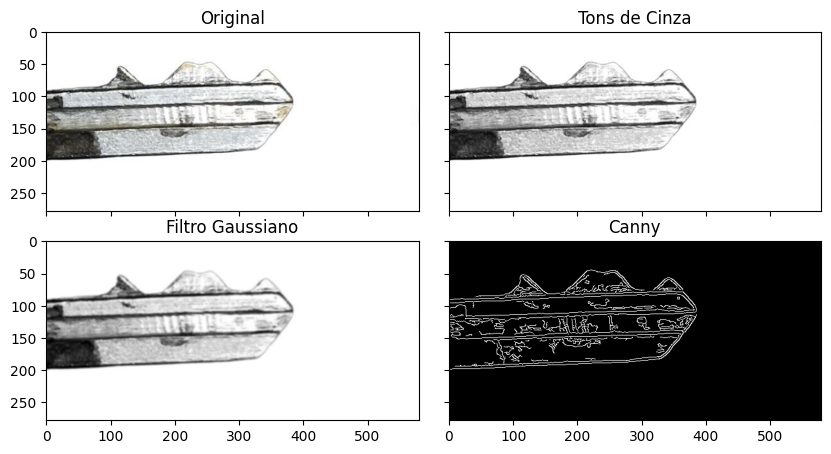

In [123]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.3)

for ax, (img, title, cmap) in zip(grid,  [
    (cv2.cvtColor(image, cv2.COLOR_BGR2RGB), "Original", None),
    (gray, "Tons de Cinza", 'gray'),
    (blur, "Filtro Gaussiano", 'gray'),
    (canny, "Canny", 'gray')
]):
    ax.imshow(img, cmap=cmap)
    ax.set_title(title)

plt.show()

In [124]:
N_PEAKS = 20

lines = cv2.HoughLinesP(canny, 1, np.pi/180, 50, minLineLength=60, maxLineGap=15)
line_props = calculate_line_properties(lines)
top_n_props = get_n_longest_line_properties(line_props, N_PEAKS)

In [125]:
N_peaks_points = [prop['points'] for prop in top_n_props]

print(f"Número de linhas obtidas: {len(N_peaks_points)}")

hough_lines_peaks_img = image.copy()
for point_coords in N_peaks_points:
    x1, y1, x2, y2 = point_coords
    cv2.line(hough_lines_peaks_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
# display_image(hough_lines_peaks_img, f"Top {len(N_peaks_points)} Linhas Mais Longas", 20)

Número de linhas obtidas: 20


In [126]:
estimated_angle, filtered_props = get_estimated_angle(top_n_props)

print("Ângulo estimado:", estimated_angle)
print(f"Número de linhas usadas para o ângulo estimado: {len(filtered_props)}")

hough_lines_peaks_filtered_img = image.copy() 

N_peaks_filtered_points = [prop['points'] for prop in filtered_props]

for point_coords in N_peaks_filtered_points:
    x1, y1, x2, y2 = point_coords
    cv2.line(hough_lines_peaks_filtered_img, (x1, y1), (x2, y2), (255, 0, 255), 2)

# display_image(hough_lines_peaks_filtered_img, f"Linhas Usadas (filtradas {len(N_peaks_filtered_points)} de {len(N_peaks_points)})", 20)


Ângulo estimado: -2.299161949232847
Número de linhas usadas para o ângulo estimado: 18


In [127]:
# display_image(hough_image_preview(image, estimated_angle), "Ângulo Estimado Final", 20)

In [128]:
# display_image(adjust_pose_to_horizontal(image, estimated_angle), "Imagem Ajustada (Para Horizontal)", 20)

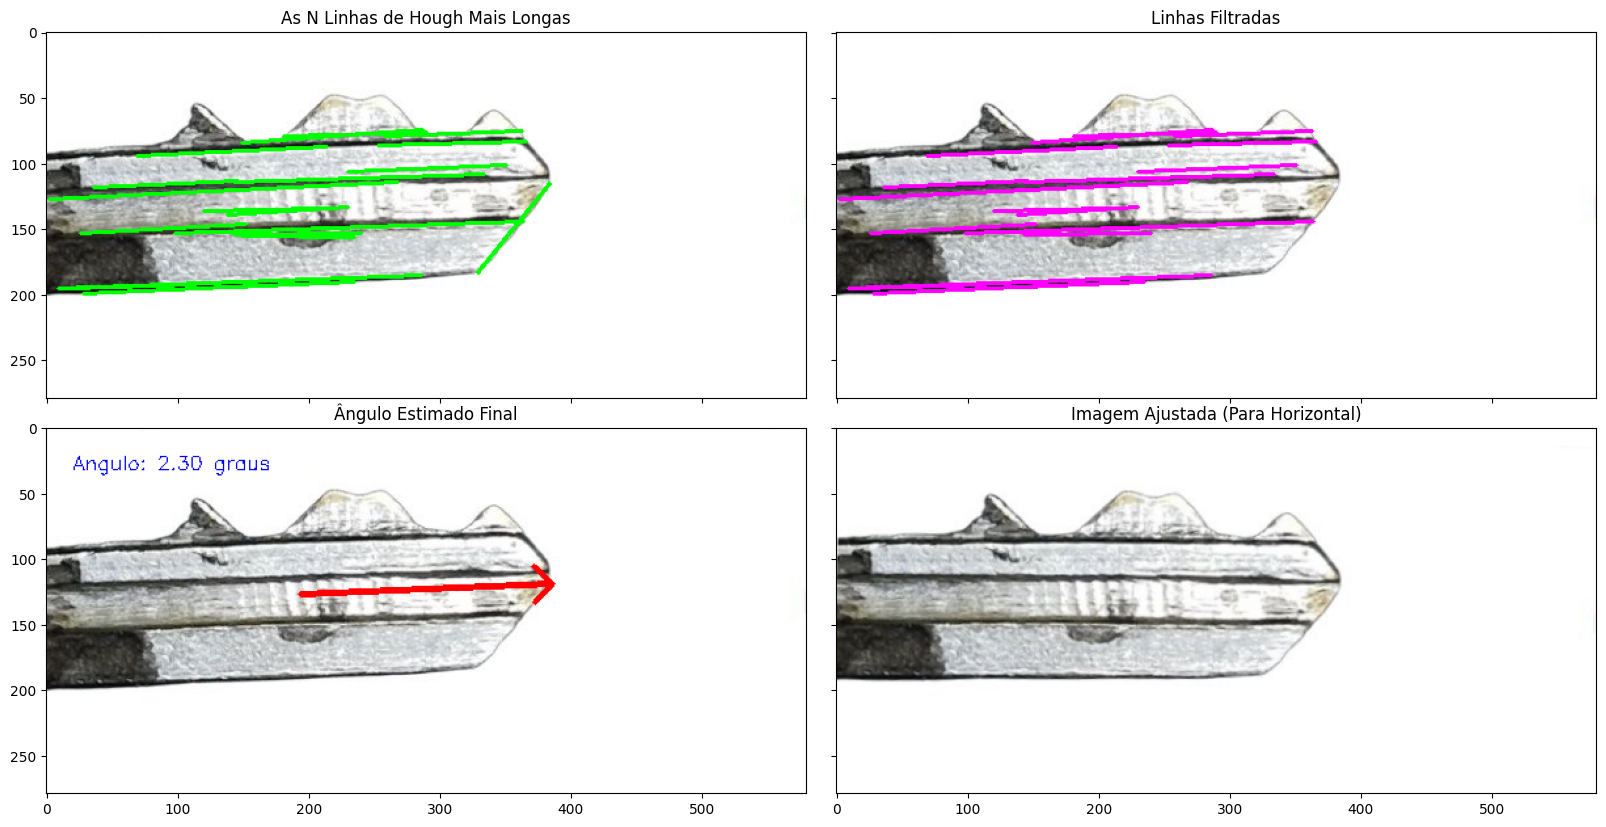

In [129]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.3)

for ax, (img, title, cmap) in zip(grid,  [
    (cv2.cvtColor(hough_lines_peaks_img, cv2.COLOR_BGR2RGB), "As N Linhas de Hough Mais Longas", None),
    (cv2.cvtColor(hough_lines_peaks_filtered_img, cv2.COLOR_BGR2RGB), "Linhas Filtradas", None),
    (cv2.cvtColor(hough_image_preview(image, estimated_angle), cv2.COLOR_BGR2RGB), "Ângulo Estimado Final", None),
    (cv2.cvtColor(adjust_pose_to_horizontal(image, estimated_angle), cv2.COLOR_BGR2RGB), "Imagem Ajustada (Para Horizontal)", None)
]):
    ax.imshow(img, cmap=cmap)
    ax.set_title(title)

plt.show()

# Referências

Base: [Rotated object detection based on improved Hough transform](https://journals.spiedigitallibrary.org/conference-proceedings-of-spie/13180/1318047/Rotated-object-detection-based-on-improved-Hough-transform/10.1117/12.3033541.short)
